# Homework 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Read the data
df = pd.read_csv("housing.csv")

In [3]:
# Take a look at the data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Select the features we'll use
features = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value',
'ocean_proximity']

data = df[features] 

In [5]:
# Fill in missing values
data = data.fillna(0)

In [6]:
# Feature engineering
data["rooms_per_household"] = data["total_rooms"] / data["households"]

data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]

data["population_per_household"] = data["population"] / data["households"]

## Question 1

In [7]:
data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Split the data

In [8]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data.drop("median_house_value", axis = 1)
y = data["median_house_value"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 42)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size = 0.5, random_state = 42)

## Question 2

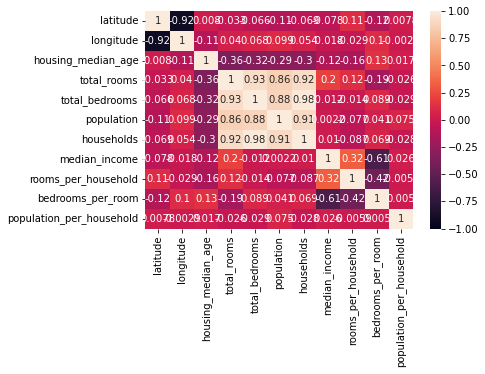

In [9]:
# Create and display correlation matrix
cm = X_train.corr()

sns.heatmap(cm, annot = True, vmin = -1, vmax = 1)
plt.show()

In [10]:
# Compare options
print("Correlation of total_bedrooms and households:", cm.loc["total_bedrooms", "households"])
print("Correlation of total_bedrooms and total_rooms:", cm.loc["total_bedrooms", "total_rooms"])
print("Correlation of population and households:", cm.loc["population", "households"])
print("Correlation of population_per_household  and total_rooms:", cm.loc["population_per_household", "total_rooms"])

Correlation of total_bedrooms and households: 0.9820137336976861
Correlation of total_bedrooms and total_rooms: 0.9282490672303043
Correlation of population and households: 0.9051678652501864
Correlation of population_per_household  and total_rooms: -0.02563100731308222


## Make `median_house_value` binary

In [11]:
y_binary_train = y_train.apply(lambda x : 1 if x > y_train.mean() else 0)
y_binary_val = y_val.apply(lambda x : 1 if x > y_val.mean() else 0)
y_binary_test = y_test.apply(lambda x : 1 if x > y_test.mean() else 0)

## Question 3

In [12]:
from sklearn.metrics import mutual_info_score

round(mutual_info_score(X_train["ocean_proximity"], y_binary_train), 2)

0.1

## Question 4

In [13]:
# One-hot encode ocean_proximity variable for all sets
for X in [X_train, X_val, X_test]:
    op_dummy = pd.get_dummies(X["ocean_proximity"])
    X.drop(columns = "ocean_proximity", inplace = True)
    X = pd.concat([X, op_dummy], axis = 0)

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

lr.fit(X_train, y_binary_train)

acc_score = round(lr.score(X_val, y_binary_val), 2)

acc_score

0.81

## Question 5

In [15]:
features = list(X_train.columns)
acc_scores = {}

for feature in features:
    current_features = [feat for feat in features if feat != feature]
    
    lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

    lr.fit(X_train[current_features], y_binary_train)

    acc_scores[feature] = lr.score(X_val[current_features], y_binary_val)
    

In [16]:
relevant_features = ["total_rooms", "total_bedrooms", "population", "households"]

acc_scores_diffs = {key : acc_score - value for key, value in acc_scores.items() if key in relevant_features}
acc_scores_diffs

{'total_rooms': -0.0010465116279069209,
 'total_bedrooms': -0.0010465116279069209,
 'population': 0.0047674418604651825,
 'households': 0.003071705426356597}

In [17]:
min(acc_scores_diffs, key = lambda x : np.abs(acc_scores_diffs[x]))

'total_rooms'

## Question 6

In [18]:
log_target = data["median_house_value"].apply(lambda x : np.log(x))

In [19]:
y_log_train = log_target.loc[y_train.index]
y_log_val = log_target.loc[y_val.index]
y_log_test = log_target.loc[y_test.index]

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

rmses = dict()

for alpha in [0, 0.01, 0.1, 1, 10]:

    rr = Ridge(alpha=alpha, solver="sag", random_state=42)
    rr.fit(X_train, y_log_train)
    
    predictions = rr.predict(X_val)
    
    rmses[alpha] = round(mean_squared_error(y_log_val, predictions, squared = False), 3)

In [21]:
min(rmses, key = rmses.get)

0